## Setup

Import TensorFlow and other necessary libraries:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB3 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, Precision, Recall

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2023-12-23 23:21:48.342846: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-23 23:21:48.361995: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-23 23:21:48.362016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-23 23:21:48.362579: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-23 23:21:48.366334: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  1


2023-12-23 23:21:49.099319: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-23 23:21:49.117626: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-23 23:21:49.117660: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Download and explore the dataset

This model uses a dataset of about 14034 photos of scenary. The dataset contains six sub-directories, one per class:

```
seg_train/
  buildings/
  forest/
  glacier/
  mountain/
  sea/
  street/
```

In [3]:
import pathlib

train_dir = pathlib.Path('seg_train')
test_dir = pathlib.Path('seg_test')

After reading, you should now have the full dataset. There are 17,034 total images, 14,034 for training and 3000 for testing:

In [4]:
image_count_train = len(list(train_dir.glob('*/*.jpg')))
image_count_test = len(list(test_dir.glob('*/*.jpg')))
print("Training: ", image_count_train)
print("Testing: ", image_count_test)

Training:  20809
Testing:  3000


Here are some buildings:

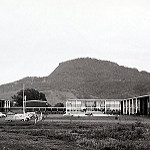

In [5]:
buildings = list(train_dir.glob('buildings/*'))
PIL.Image.open(str(buildings[0]))

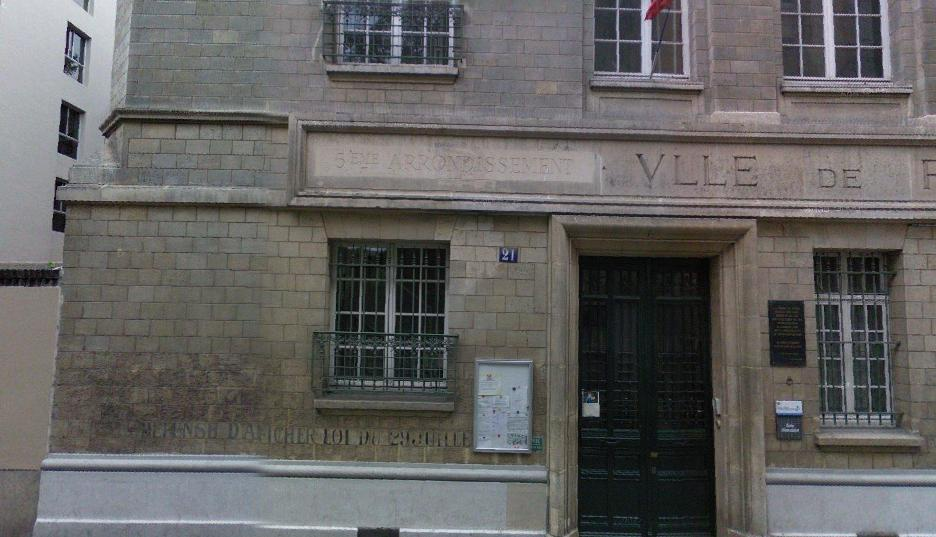

In [6]:
PIL.Image.open(str(buildings[1]))

And some glacier:

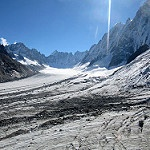

In [7]:
glacier = list(train_dir.glob('glacier/*'))
PIL.Image.open(str(glacier[0]))

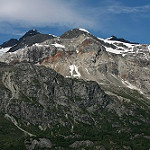

In [8]:
PIL.Image.open(str(glacier[1]))

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 150
img_width = 150

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 31482 files belonging to 6 classes.
Using 25186 files for training.


2023-12-23 23:22:23.669135: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-23 23:22:23.669179: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-23 23:22:23.669188: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-23 23:22:23.750514: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-23 23:22:23.750550: I external/local_xla/xla/stream_executor

In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 31482 files belonging to 6 classes.
Using 6296 files for validation.


In [12]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3000 files belonging to 6 classes.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [13]:
class_names = train_ds.class_names
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## Visualize the data

Here are the first nine images from the training dataset:

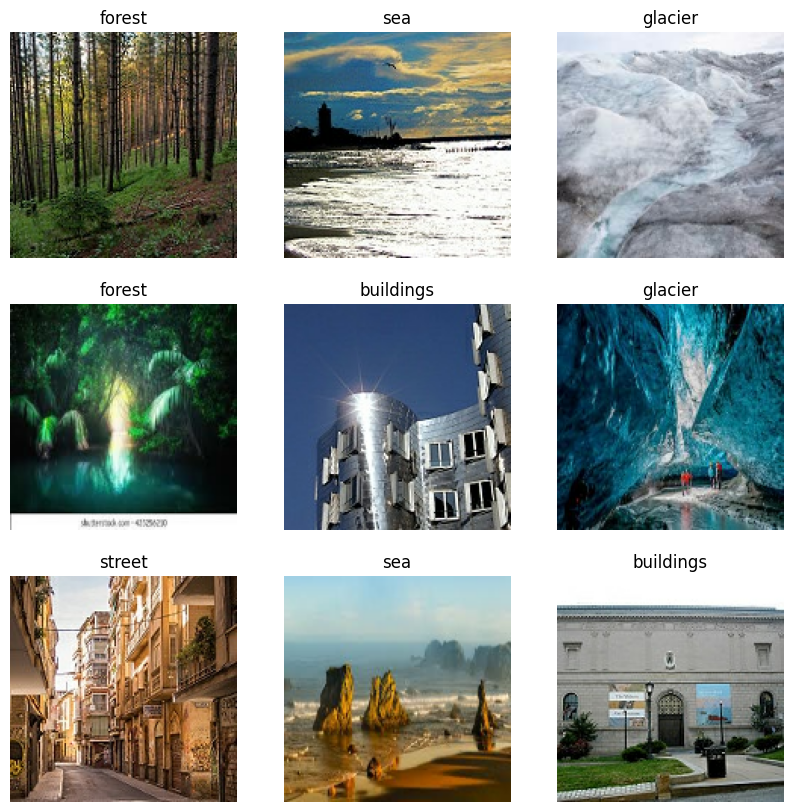

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2023-12-23 23:23:12.528160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:25: Filling up shuffle buffer (this may take a while): 436 of 1000


0.0 1.0


2023-12-23 23:23:20.280177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

## Constructing the Model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [19]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),  # Reduced rotation range
])

In [20]:
num_classes = len(class_names)
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = Sequential([
        data_augmentation,
        layers.Rescaling(1./255),
        
        # First Conv Block
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
    
        # Second Conv Block
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
    
        # Classifier
        layers.Flatten(),
        layers.Dense(128, activation='relu'),  # Reduced dense layer units
        layers.Dense(num_classes, activation='softmax', name="outputs")  # Softmax for multi-class classification
    ])

    # Compilation (use Sparse Categorical Crossentropy for integer-encoded labels)
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                 

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [22]:
epochs=45
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/45
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tens

2023-12-23 23:23:28.861366: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-23 23:23:29.016132: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-23 23:23:29.248187: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f221874e7a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-23 23:23:29.248213: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2023-12-23 23:23:29.251000: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1703334209.300853    3841 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


786/788 [============================>.] - ETA: 0s - loss: 0.9658 - accuracy: 0.6544INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
788/788 [==============================] - 15s 17ms/step - loss: 0.9652 - accuracy: 0.6547 - val_loss: 0.7540 - val_accuracy: 0.7322
Epoch 2/45
788/788 [==============================] - 10s 12ms/step - loss: 0.7219 - accuracy: 0.7388 - val_loss: 0.6775 - val_accuracy: 0.7659
Epoch 3/45
788/788 [==============================] - 10s 12ms/step - loss: 0.6366 - accuracy: 0.7731 - val_loss: 0.6350 - val_accuracy: 0.7730
Epoch 4/45
788/788 [==============================] - 10s 12ms/step - loss: 0.5867 - accuracy: 0.7895 - val_loss: 0.5821 - val_accuracy: 0.7972
Epoch 5/45
788/788 [==============================] - 10s 12ms/step - l

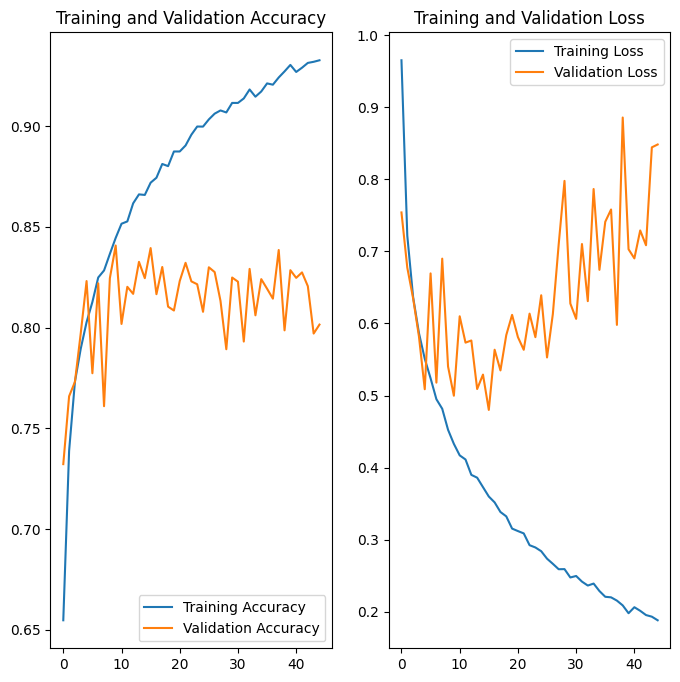

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

94/94 [==============================] - 2s 21ms/step - loss: 0.9629 - accuracy: 0.7847
Test Loss: 0.9629338979721069
Test Accuracy: 0.7846666574478149


In [ ]:
# import os
# seg_pred_dir = 'seg_pred/seg_pred'  # Replace with the correct path

# # Prepare a list of image filenames
# image_files = [f for f in os.listdir(seg_pred_dir) if f.endswith(".jpg") or f.endswith(".png")]

# # Set how many images to display per batch
# batch_size = 10  # Adjust this number as needed

# # Function to plot a batch of images
# def plot_batch(image_batch):
#     num_images = len(image_batch)
#     fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))
#     if num_images == 1:
#         axes = [axes]

#     for i, filename in enumerate(image_batch):
#         img_path = os.path.join(seg_pred_dir, filename)
        
#         # Load and preprocess the image
#         img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
#         img_array = tf.keras.utils.img_to_array(img)
#         img_array = tf.expand_dims(img_array, 0)  # Create a batch

#         # Make predictions
#         predictions = model.predict(img_array)
#         score = tf.nn.softmax(predictions[0])

#         # Get top 3 predictions
#         # Get top 3 predictions
#         # Get top 3 predictions
#         top_3_indices = np.argsort(score)[-3:][::-1]
#         top_3_scores = score.numpy()[top_3_indices]  # Convert the entire score tensor to numpy array first
#         top_3_class_names = [class_names[idx] for idx in top_3_indices]
        
#         prediction_text = "\n".join(
#             "{}: {:.2f}%".format(class_name, 100 * conf_score) 
#             for class_name, conf_score in zip(top_3_class_names, top_3_scores)
#         )



#         # Plot the image
#         axes[i][0].imshow(img)
#         axes[i][0].axis('off')
#         axes[i][0].set_title(filename)

#         # Plot the prediction
#         axes[i][1].text(0.5, 0.5, prediction_text, fontsize=12, ha='center', va='center')
#         axes[i][1].axis('off')

#     plt.tight_layout()
#     plt.show()

# # Iterate over the images in batches and plot each batch
# for i in range(0, len(image_files), batch_size):
#     plot_batch(image_files[i:i + batch_size])

In [25]:
model.save("scenary_classification_model")

INFO:tensorflow:Assets written to: scenary_classification_model/assets


INFO:tensorflow:Assets written to: scenary_classification_model/assets
